In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F
import numpy as np

In [3]:
# --- Load embeddings ---
with open("embeddings/rmvbg_train.pkl", "rb") as f:
    X_train, y_train, class_names = pickle.load(f)

with open("embeddings/rmvbg_test.pkl", "rb") as f:
    X_test, y_test, _ = pickle.load(f)

with open("embeddings/rmvbg_forward.pkl", "rb") as f:
    X_fw, y_fw, _ = pickle.load(f)

In [4]:
# --- Encode labels to 0..N-1 ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_fw_enc = le.transform(y_fw)

# --- Convert to tensors ---
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
X_fw_t = torch.tensor(X_fw, dtype=torch.float32)
y_train_t = torch.tensor(y_train_enc, dtype=torch.long)
y_test_t = torch.tensor(y_test_enc, dtype=torch.long)
y_fw_t = torch.tensor(y_fw_enc, dtype=torch.long)

# --- Dataloaders ---
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=32)
fw_loader = DataLoader(TensorDataset(X_fw_t, y_fw_t), batch_size=32)

In [5]:
# --- CNN-like classifier ---
class CLIP_CNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.net(x)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIP_CNN(X_train.shape[1], len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [7]:
# --- Train ---
EPOCHS = 25
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/25 | Loss: 1.3876
Epoch 2/25 | Loss: 1.3873
Epoch 3/25 | Loss: 1.3838
Epoch 4/25 | Loss: 1.3842
Epoch 5/25 | Loss: 1.3821
Epoch 6/25 | Loss: 1.3813
Epoch 7/25 | Loss: 1.3795
Epoch 8/25 | Loss: 1.3789
Epoch 9/25 | Loss: 1.3771
Epoch 10/25 | Loss: 1.3737
Epoch 11/25 | Loss: 1.3729
Epoch 12/25 | Loss: 1.3681
Epoch 13/25 | Loss: 1.3636
Epoch 14/25 | Loss: 1.3595
Epoch 15/25 | Loss: 1.3558
Epoch 16/25 | Loss: 1.3459
Epoch 17/25 | Loss: 1.3429
Epoch 18/25 | Loss: 1.3329
Epoch 19/25 | Loss: 1.3225
Epoch 20/25 | Loss: 1.3089
Epoch 21/25 | Loss: 1.2991
Epoch 22/25 | Loss: 1.2856
Epoch 23/25 | Loss: 1.2704
Epoch 24/25 | Loss: 1.2581
Epoch 25/25 | Loss: 1.2361


In [8]:
# --- Evaluate ---
def evaluate(loader, name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds = model(xb).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())
    print(f"\n--- {name} Evaluation ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print(confusion_matrix(all_labels, all_preds))

evaluate(test_loader, "Internal Test")
evaluate(fw_loader, "Forward Test")


--- Internal Test Evaluation ---
              precision    recall  f1-score   support

     RMVBG_A       0.75      0.60      0.67        25
     RMVBG_B       0.50      0.58      0.54        26
     RMVBG_C       0.00      0.00      0.00        24
     RMVBG_D       0.53      1.00      0.69        28

    accuracy                           0.56       103
   macro avg       0.44      0.54      0.47       103
weighted avg       0.45      0.56      0.48       103

[[15  5  0  5]
 [ 5 15  0  6]
 [ 0 10  0 14]
 [ 0  0  0 28]]

--- Forward Test Evaluation ---
              precision    recall  f1-score   support

     RMVBG_A       0.80      0.60      0.69        20
     RMVBG_B       0.39      0.36      0.38        25
     RMVBG_C       0.00      0.00      0.00        25
     RMVBG_D       0.36      0.87      0.51        23

    accuracy                           0.44        93
   macro avg       0.39      0.46      0.39        93
weighted avg       0.37      0.44      0.38        93

[[

e:\Jain Irrigation\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\Jain Irrigation\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\Jain Irrigation\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\Jain Irrigation\venv\lib\sit

In [8]:
# --- Save model ---
torch.save(model.state_dict(), "clip_cnn_classifier.pth")
print("✅ Model saved as clip_cnn_classifier.pth")

✅ Model saved as clip_cnn_classifier.pth


In [9]:
class DeepCLIPNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc_out = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.6)  # stronger regularization

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x_res = x
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = x + x_res  # residual
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc_out(x)
        return x

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DeepCLIPNet(input_dim=X_train.shape[1], num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

EPOCHS = 60
patience = 8  # stop if no improvement for these many epochs
best_val_loss = float('inf')
patience_counter = 0

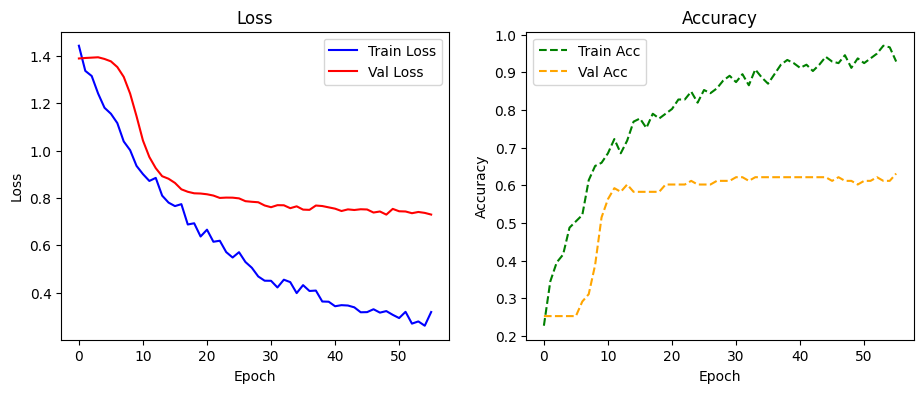

Epoch 56/60 | Train Loss: 0.3185 | Val Loss: 0.7301 | Train Acc: 0.929 | Val Acc: 0.631

⏹ Early stopping at epoch 57


In [11]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


train_losses, val_losses, train_accs, val_accs = [], [], [], []

plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))

# ---------- Training Loop ----------
for epoch in range(EPOCHS):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (preds.argmax(1) == yb).sum().item()
        total += yb.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()
            val_correct += (preds.argmax(1) == yb).sum().item()
            val_total += yb.size(0)
    val_loss /= len(test_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # ---------- Early Stopping Check ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_clipnet.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⏹ Early stopping at epoch {epoch+1}")
            break

    # ---------- Live Plot ----------
    clear_output(wait=True)
    ax1.cla(); ax2.cla()
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='red')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.set_title('Loss')

    ax2.plot(train_accs, label='Train Acc', color='green', linestyle='--')
    ax2.plot(val_accs, label='Val Acc', color='orange', linestyle='--')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.set_title('Accuracy')
    display(fig); plt.pause(0.001)

    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

plt.ioff()
plt.show()


In [18]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


--- Training (70%) ---
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        57
           B       1.00      1.00      1.00        61
           C       1.00      1.00      1.00        56
           D       1.00      1.00      1.00        64

    accuracy                           1.00       238
   macro avg       1.00      1.00      1.00       238
weighted avg       1.00      1.00      1.00       238



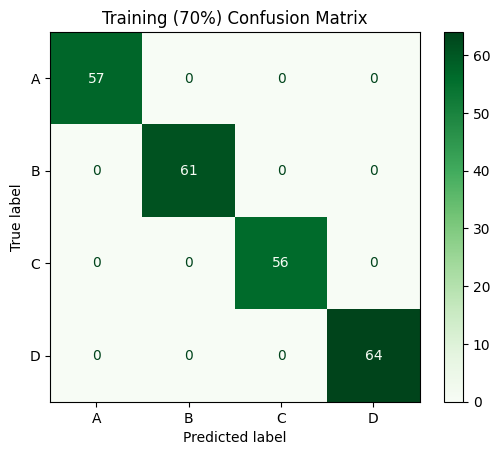


--- Internal Test (30%) ---
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        25
           B       0.86      0.92      0.89        26
           C       0.90      0.79      0.84        24
           D       0.97      1.00      0.98        28

    accuracy                           0.93       103
   macro avg       0.93      0.93      0.93       103
weighted avg       0.93      0.93      0.93       103



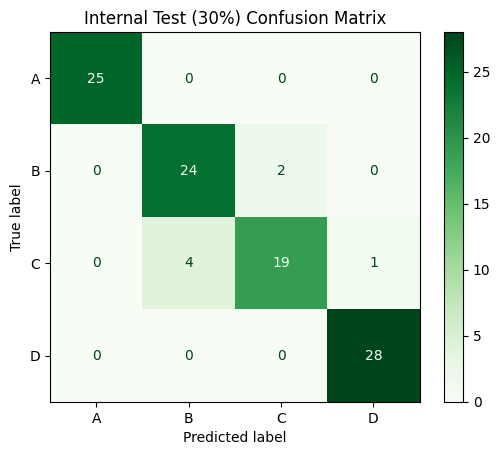


--- Forward Test ---
              precision    recall  f1-score   support

           A       1.00      0.85      0.92        20
           B       0.53      0.40      0.45        25
           C       0.55      0.68      0.61        25
           D       0.88      1.00      0.94        23

    accuracy                           0.72        93
   macro avg       0.74      0.73      0.73        93
weighted avg       0.72      0.72      0.72        93



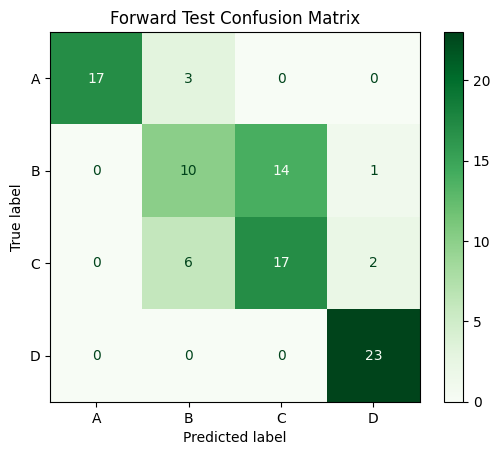

array([[17,  3,  0,  0],
       [ 0, 10, 14,  1],
       [ 0,  6, 17,  2],
       [ 0,  0,  0, 23]])

In [24]:
def evaluate(loader, name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds = model(xb).argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())
    print(f"\n--- {name} ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap='Greens')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    return cm

# Load best model before evaluation
model.load_state_dict(torch.load("best_clipnet.pth"))

evaluate(train_loader, "Training (70%)")
evaluate(test_loader, "Internal Test (30%)")
evaluate(fw_loader, "Forward Test")

In [12]:
import pickle

metadata = {
    "input_dim": X_train.shape[1],
    "class_names": class_names
}
with open("saved_models/model_meta.pkl", "wb") as f:
    pickle.dump(metadata, f)
print("✅ Saved best_clipnet.pth and model_meta.pkl")


✅ Saved best_clipnet.pth and model_meta.pkl
